# Don’t be Afraid of Nonparametric Topic Models (Part 2: Python)

### Dive into an easy step-by-step tutorial on how to implement/evaluate a Hierarchical Dirichlet Process model

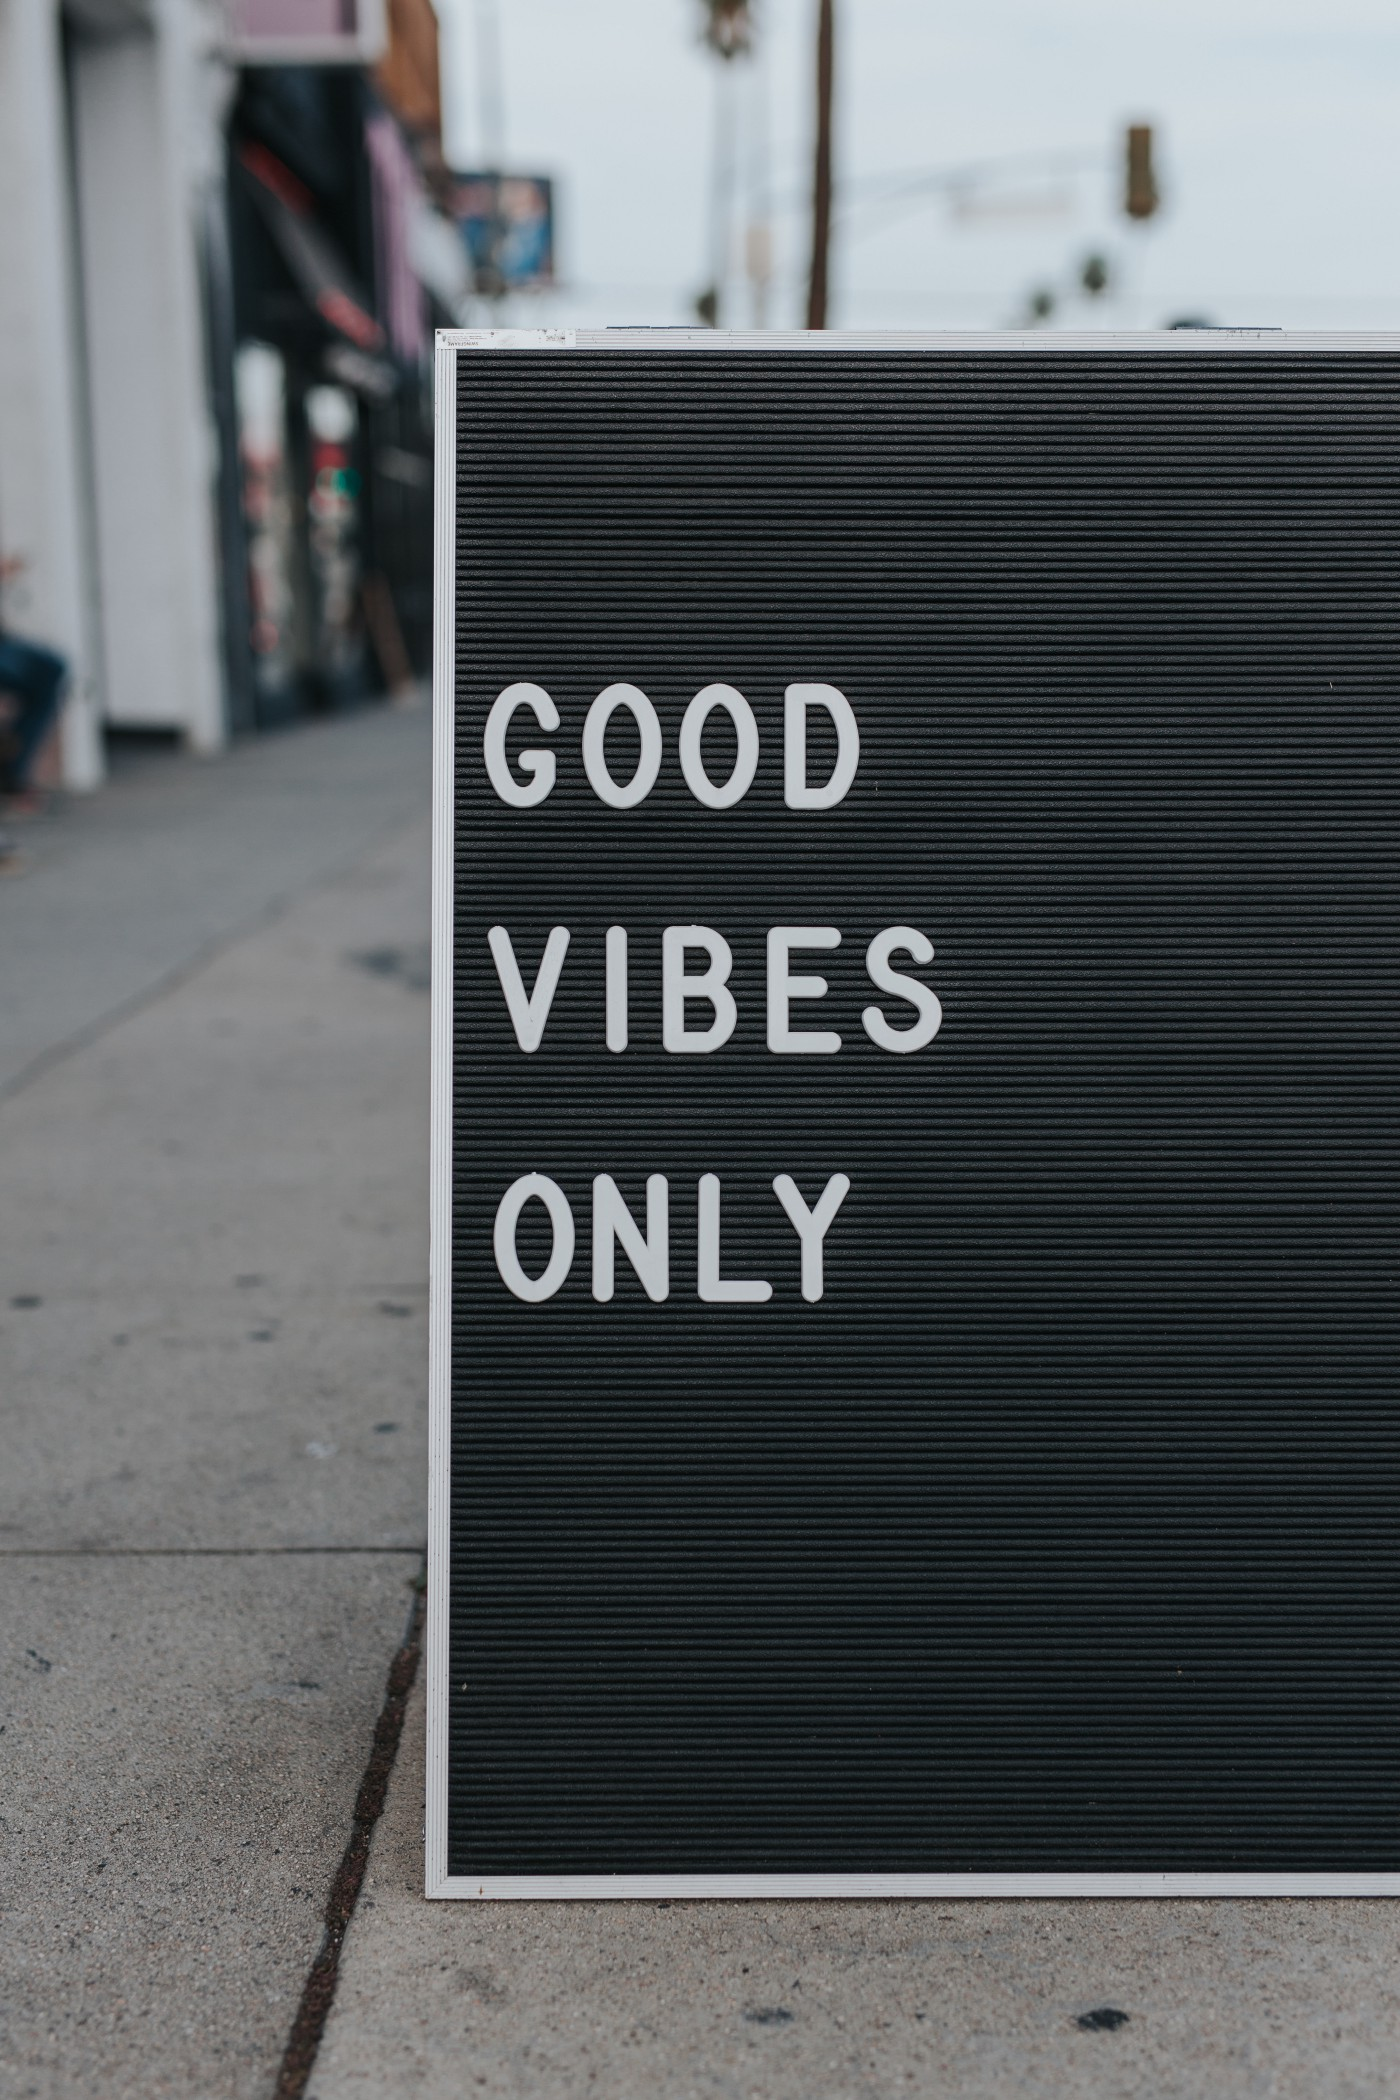

## Load packages

In [998]:
import pandas as pd
from pandas import option_context
import numpy as np
import string
import re
import sys

# Sklearn
"""
The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

Link to import: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups
"""
from sklearn.datasets import fetch_20newsgroups

# Plotting
import matplotlib.pyplot as plt



### Prep stopwords

In [999]:
import nltk
nltk.download('stopwords', quiet=True) # downloads and installs the stop words package from Natural Language Toolkit

from nltk.corpus import stopwords # imports a list of stopwords from the corpus package
st_words = stopwords.words('english') # assigns an array of english stopwords to variable
st_words.extend(['title']) # appends additional stopwords to the list of stopwords

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


### Read Titles.txt from directory

In [1000]:
#news = fetch_20newsgroups(subset='train') # import fron skleanr
depth = "depth1"
with open(f"/Users/jaden/Documents/Fall 2024/CS 594/linux-titles/{depth}/Titles.txt", "r") as file:
    lines = file.readlines()
    for line in lines:
        print(line)

title 3 is: AnonGTS

title 4 is: Juvenile Communications

title 6 is: Ransomware Group Sites

title 7 is: Main Page :: Kaizushi's Little Onion Server

title 8 is: VormWeb – Suchmaschine

title 11 is: Site Offline

title 12 is: BBC - Home

title 16 is: mail.riseup.net :: Welcome to mail.riseup.net

title 18 is: Cizzuk

title 20 is: Poast

title 21 is: Reddit - Dive into anything

title 22 is: Reddit - Dive into anything

title 24 is: Dark Mining - Bitcoin mining with real profits

title 25 is: US Fake ID Store - Drivers Licenses for most states with real holograms

title 26 is: Dark Mixer anonymous bitcoin mixer

title 27 is: DarkForest

title 28 is: The DEF CON® Media Server - Archives of the conferences

title 29 is: Electronic Frontier Foundation | Defending your rights in the digital world

title 31 is: UK Passports - Buy real UK passports, become a UK citizen now. Our passports are no fake passports, they are real passports.

title 33 is: Главная - Беллингкэт

title 34 is: Radio Fr

In [1001]:
# Build master df
"""
Constructs a pandas DataFrame where:
The first column contains the target labels (integers representing the newsgroups).
The second column contains the actual text of the newsgroup posts.

.T transposes the DataFrame. This means that the rows and columns are swapped, turning the list of [news.target, news.data] into a DataFrame with two columns: one for news.target (category labels) and one for news.data (text).
After transposition, the DataFrame will have one row for each document, and two columns:
Column 0: Target category (as integers).
Column 1: The document text (raw text data).

"""
topic_df = pd.DataFrame([lines]).T
"""news_df = news_df.set_index(0)
news_df.reset_index(inplace=True)"""
#news_df = pd.concat([news_df, pd.Series(news.target_names)],axis=1, join="inner") # Attempts to concatenate the DataFrame with a new column containing newsgroup names.

topic_df.columns = ["title-lines"] # renames the DataFrame columns to reflect the topic_id, content, and the newly added topic_name.
topic_df.head() # news_df.head() returns the first 5 rows of the news_df DataFrame

title-lines
0                              title 3 is: AnonGTS\n
1              title 4 is: Juvenile Communications\n
2               title 6 is: Ransomware Group Sites\n
3  title 7 is: Main Page :: Kaizushi's Little Oni...
4               title 8 is: VormWeb – Suchmaschine\n

In [1002]:
"""
This line extracts all the text data from the content column of the news_df DataFrame and stores it as a Python list called doc_list. Each element of the list is a document from the newsgroup dataset.
"""
doc_list = topic_df.values.tolist()

In [1003]:
doc_list[0] # prints the first text data in the content column

['title 3 is: AnonGTS\n']

In [1004]:
doc_list = [' '.join(sent) if isinstance(sent, list) else sent for sent in doc_list] # converts the lists containing strings of the original data to simply strings
print([sent for sent in doc_list]) # prints all the sentences line by line in the document

['title 3 is: AnonGTS\n', 'title 4 is: Juvenile Communications\n', 'title 6 is: Ransomware Group Sites\n', "title 7 is: Main Page :: Kaizushi's Little Onion Server\n", 'title 8 is: VormWeb – Suchmaschine\n', 'title 11 is: Site Offline\n', 'title 12 is: BBC - Home\n', 'title 16 is: mail.riseup.net :: Welcome to mail.riseup.net\n', 'title 18 is: Cizzuk\n', 'title 20 is: Poast\n', 'title 21 is: Reddit - Dive into anything\n', 'title 22 is: Reddit - Dive into anything\n', 'title 24 is: Dark Mining - Bitcoin mining with real profits\n', 'title 25 is: US Fake ID Store - Drivers Licenses for most states with real holograms\n', 'title 26 is: Dark Mixer anonymous bitcoin mixer\n', 'title 27 is: DarkForest\n', 'title 28 is: The DEF CON® Media Server - Archives of the conferences\n', 'title 29 is: Electronic Frontier Foundation | Defending your rights in the digital world\n', 'title 31 is: UK Passports - Buy real UK passports, become a UK citizen now. Our passports are no fake passports, they are

### Removing @s, new lines and single quotes

In [1005]:
# Remove Emails
doc_list = [re.sub(r'\S*@\S*\s?', '', sent) for sent in doc_list]

# Remove new line characters
doc_list = [re.sub(r'\s+', ' ', sent) for sent in doc_list]

# Remove distracting single quotes
doc_list = [re.sub(r"\'", "", sent) for sent in doc_list]


In [1006]:
doc_list[3]

'title 7 is: Main Page :: Kaizushis Little Onion Server '

### Removing punctuations, lowercasing and splitting text into lists

In [1007]:
# Gensim
import gensim
"""
# removes converts each word in doc_list into lowercase, removes all accents from all words in each document,
and removes words that are shorter than 3 letters
"""
word_list = [gensim.utils.simple_preprocess(txt, deacc=True, min_len=3) for txt in doc_list]

In [1008]:
word_list[3][:10]

['title', 'main', 'page', 'kaizushis', 'little', 'onion', 'server']

### Bigram model to capture co-occurent words

In [1009]:

from gensim.models import Phrases
from gensim.models.phrases import Phraser

"""
"min_count" Ignores all words and bigrams that occur less than 5 times.

"threshold" Controls the sensitivity of bigram detection.
A higher threshold makes it harder for word pairs to be considered
as a bigram (it’s a scoring parameter based on how likely the words are to co-occur).

"""
bigram = Phrases(word_list, min_count=5, threshold=100)

bigram_model = Phraser(bigram)


### Remove standard and extended Stopwords

In [1010]:
# Example of stop word removal process
sentence = "A letter has been written asking him to be released"
for word in sentence.split():
    if word not in st_words:
        print("Kept ==> " +word)
    else:
        print("Removed: " +word)

Kept ==> A
Kept ==> letter
Removed: has
Removed: been
Kept ==> written
Kept ==> asking
Removed: him
Removed: to
Removed: be
Kept ==> released


In [1011]:
"""
This line removes stopwords from the tokenized documents.
The result, word_list_nostops, is a list of documents (each represented as a list of words) with stopwords filtered out.

Note: This line uses list comprehension and creates a new list called "word_list_nostops". This loop
goes through each document (txt) in word_list, and then it goes over each word (word) in the document (txt).
If any of the words in the document are stop words they are ignored. If any of the words in the document are NOT stop words they are appended to the
list word_list_nostops.

link to list comprehension: https://www.w3schools.com/python/python_lists_comprehension.asp

"""
word_list_nostops = [[word for word in txt if word not in st_words] for txt in word_list]

In [1012]:
word_list_nostops[3][:6]

['main', 'page', 'kaizushis', 'little', 'onion', 'server']

### Create Bigrams

In [1013]:
"""
When you apply bigram_model to w_vec, it looks for pairs of words (bigrams) that frequently appear together according to the bigram model created earlier.
"""
word_bigrams = [bigram_model[w_vec] for w_vec in word_list_nostops]

In [1014]:
word_bigrams[3][:7]

['main', 'page', 'kaizushis', 'little', 'onion', 'server']

### Word Lemmatization

In [1015]:
import spacy

## Example showing lemmatization
sentence = "A letter has been written asking him to be released"

spC = spacy.load('en_core_web_sm')

lemma_sentence = spC(sentence)
for token in lemma_sentence:
    print(token.text + " ==> " +token.lemma_ + ", " + token.pos_) #POS = Part Of Speech

A ==> a, DET
letter ==> letter, NOUN
has ==> have, AUX
been ==> be, AUX
written ==> write, VERB
asking ==> ask, VERB
him ==> he, PRON
to ==> to, PART
be ==> be, AUX
released ==> release, VERB


In [1016]:

spC = spacy.load('en_core_web_sm')
postags = ['NOUN','VERB', 'ADV', 'ADJ'] # Keep nouns, adj, verbs, and adverbs


def lemmatize(word_list, ptags = postags ):
    '''Lemmatizes words based on allowed postags, input format is list of sublists 
       with strings'''
    
    lem_lists =[]
    for vec in word_list:
        sentence = spC(" ".join(vec))
        lem_lists.append([token.lemma_ for token in sentence if token.pos_ in ptags])
    
    return lem_lists


In [1017]:
# Lemmatize bigrams
word_list_lemmatized = lemmatize(word_bigrams)


In [1018]:
word_list_lemmatized[3][:7]

['main', 'page', 'kaizushis', 'little', 'onion', 'server']

#### (Alternative, tried using stemming with no improvement)

In [1019]:
from gensim.parsing.porter import PorterStemmer
p = PorterStemmer()
def stemming(word_list):
    '''Lemmatizes words based on allowed postags, input format is list of sublists 
       with strings'''
    
    lem_lists =[]
    for vec in word_list:
        lem_lists.append([p.stem(token) for token in vec])
    
    return lem_lists

word_list_stem = stemming(word_bigrams)

## HDP Model

<img src="imgs/HDP.png" style="width:70%; height:90%;">

In [1020]:
import tomotopy as tp # uses collapsed gibbs sampling
# "min_cf" removes words that appear less than 5 times over all documents
# "rm_top" removes the top 7 occurring words across all documents
# "gamma" allows the concentration to be diffused, meaning the higher the gamma value, the more we are inferring documents share a lot of topics.
# "alpha" a low number of alpha infers that there are not a lot of topics in each individual document. Also, reducing "alpha" results in less spikes in the graph above for G1 and G2 meaning less topics per document.
# "initial_k" initializes the amount of assumed topics across all documents
hdp = tp.HDPModel(tw=tp.TermWeight.IDF, min_cf=5, rm_top=7,
                 gamma=1, alpha=0.1, initial_k=50, seed=99999)

# Add docs to train and add tokens to the hdp model
for vec in word_list_lemmatized:
    hdp.add_doc(vec)

# open file for writing
file = open(f"{depth}HDP.txt", "a+")
# Initiate MCMC burn-in
hdp.burn_in = 100
hdp.train(0)
print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs, ', Num words:', hdp.num_words)
file.write(f'Num docs: {len(hdp.docs)} , Vocab size: {hdp.num_vocabs} , Num words:{hdp.num_words} ')
print('Removed top words:', hdp.removed_top_words)
file.write(f'\nRemoved top words:{hdp.removed_top_words}')
file.write('\n________________________________________________________________________________________________________________________________\n')
print("________________________________________________________________________________________________________________________________")
print('Training...', file=sys.stderr, flush=True)


/var/folders/p4/gk0s61d14tq4_l0l3m84p6jc0000gn/T/ipykernel_80527/1654026981.py:18: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(0)
Training...


Num docs: 342 , Vocab size: 44 , Num words: 354
Removed top words: ['bitcoin', 'onion', 'tor', 'link', 'buy', 'hide', 'search']
________________________________________________________________________________________________________________________________


In [1021]:
# Train model
mcmc_iter=1000 # number of iterations you want to train model
for i in range(0, mcmc_iter, 100): # prints an update message every 100 iterations
    hdp.train(100, workers=3)
    print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))
    file.write('Iteration: {}\t Log-likelihood: {}\t Num. of topics: {}\n'.format(i, hdp.ll_per_word, hdp.live_k))
print("________________________________________________________________________________________________________________________________\n")
file.write("________________________________________________________________________________________________________________________________\n")

Iteration: 0	Log-likelihood: -2.1659034348707236	Num. of topics: 28
Iteration: 100	Log-likelihood: -2.0196896564721456	Num. of topics: 62
Iteration: 200	Log-likelihood: -2.0024674638472195	Num. of topics: 58
Iteration: 300	Log-likelihood: -2.076501436836156	Num. of topics: 53
Iteration: 400	Log-likelihood: -2.0874382617006386	Num. of topics: 57
Iteration: 500	Log-likelihood: -1.9542011274961448	Num. of topics: 68
Iteration: 600	Log-likelihood: -2.0205165839593278	Num. of topics: 65
Iteration: 700	Log-likelihood: -2.0209860544587914	Num. of topics: 61
Iteration: 800	Log-likelihood: -2.0376716045856877	Num. of topics: 57
Iteration: 900	Log-likelihood: -2.0840366565199315	Num. of topics: 60
________________________________________________________________________________________________________________________________



/var/folders/p4/gk0s61d14tq4_l0l3m84p6jc0000gn/T/ipykernel_80527/1182803217.py:4: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(100, workers=3)


129

#### Get topics

In [1022]:
def get_hdp_topics(hdp, top_n=7):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    hdp:obj -> HDPModel trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        topic_wp =[]
        for word, prob in hdp.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics

In [1023]:
hdp_topics = get_hdp_topics(hdp)

In [1024]:

# hdp_topics[0]
# print([hdp_topic for hdp_topic in hdp_topics])
file.write(f"Below are arrays with top words and associated frequencies [(word, associated_frequency)]\n\n")
for key in hdp_topics:
    print(f"Topic {key}:")
    file.write(f"Topic {key}:\n")
    print(f"{hdp_topics[key]}\n")
    file.write(f"{hdp_topics[key]}\n")

Topic 25:
[('topic', 0.20387759804725647), ('list', 0.1283455789089203), ('card', 0.10093282163143158), ('directory', 0.10093282163143158), ('porn', 0.08885002881288528), ('trust', 0.07095697522163391), ('wiki', 0.06532202661037445)]

Topic 32:
[('usd', 0.3228519856929779), ('counterfeit', 0.29343196749687195), ('good', 0.13204218447208405), ('quality', 0.12270791083574295), ('market', 0.07488620281219482), ('fake', 0.05133143812417984), ('web', 7.255889067891985e-05)]

Topic 57:
[('drug', 0.2619762122631073), ('cocaine', 0.24564379453659058), ('store', 0.22812199592590332), ('cannabis', 0.12693972885608673), ('online', 0.09050657600164413), ('good', 0.042390719056129456), ('wiki', 0.00011622135934885591)]

Topic 11:
[('passport', 0.6107237935066223), ('real', 0.2811235189437866), ('fake', 0.10222799330949783), ('service', 0.00014450651360675693), ('web', 0.0001445030648028478), ('market', 0.0001445030648028478), ('counterfeit', 0.0001445030648028478)]

Topic 45:
[('gun', 0.75777888298

#### Evaluate coherence

In [1025]:
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Build gensim objects
vocab = corpora.Dictionary(word_list_lemmatized)
corpus = [vocab.doc2bow(words) for words in word_list_lemmatized]

# Build topic list from dictionary
topic_list=[]
for k, tups in hdp_topics.items():
    topic_tokens=[]
    for w, p in tups:
        topic_tokens.append(w)

    topic_list.append(topic_tokens)



In [1026]:
topic_list[3]

['passport', 'real', 'fake', 'service', 'web', 'market', 'counterfeit']

In [1027]:
cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab, texts=word_list_lemmatized, 
                    coherence='c_v')
file.write('\n________________________________________________________________________________________________________________________________\n')
file.write(f"\nCoherence of Documents: {cm.get_coherence()}\n")
file.close()
cm.get_coherence()

0.3454390671696005

#### Inference

In [1028]:
test_doc = word_list_lemmatized[2]

doc_inst = hdp.make_doc(test_doc)

topic_dist, ll = hdp.infer(doc_inst)

topic_idx = np.array(topic_dist).argmax()
topic_idx

43

In [1029]:
hdp.get_topic_words(topic_idx)

[('directory', 0.3622075021266937),
 ('site', 0.3080390989780426),
 ('wiki', 0.29311004281044006),
 ('topic', 0.0008940063999034464),
 ('porn', 0.0008937080856412649),
 ('market', 0.0008936654776334763),
 ('counterfeit', 0.0008936654776334763),
 ('fake', 0.0008936654776334763),
 ('gun', 0.0008936654776334763),
 ('cannabis', 0.0008936654776334763)]

In [1030]:
topic_df.head(10)

title-lines
0                              title 3 is: AnonGTS\n
1              title 4 is: Juvenile Communications\n
2               title 6 is: Ransomware Group Sites\n
3  title 7 is: Main Page :: Kaizushi's Little Oni...
4               title 8 is: VormWeb – Suchmaschine\n
5                        title 11 is: Site Offline\n
6                          title 12 is: BBC - Home\n
7  title 16 is: mail.riseup.net :: Welcome to mai...
8                              title 18 is: Cizzuk\n
9                               title 20 is: Poast\n

#### Word Clouds

In [1031]:
from scripts.wordcloud_funcs import hdp_topics_to_wordclouds

/Users/jaden/Documents/Fall 2024/hdp/hdp_example/scripts/wordcloud_funcs.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 3, figsize=(15,4))


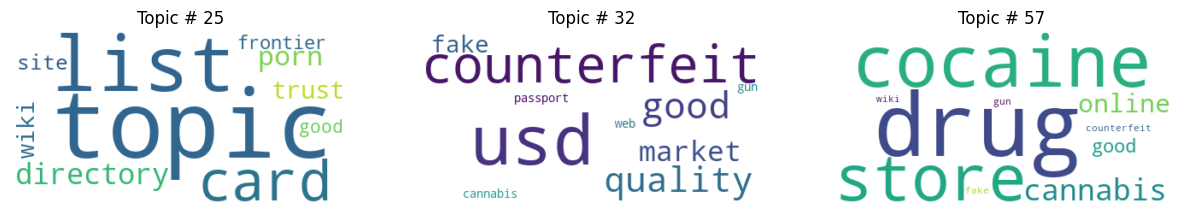

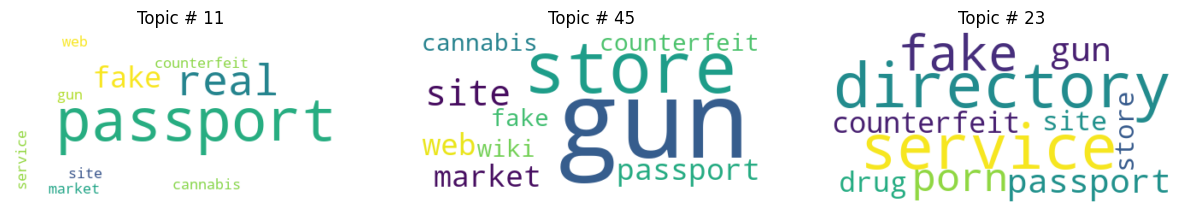

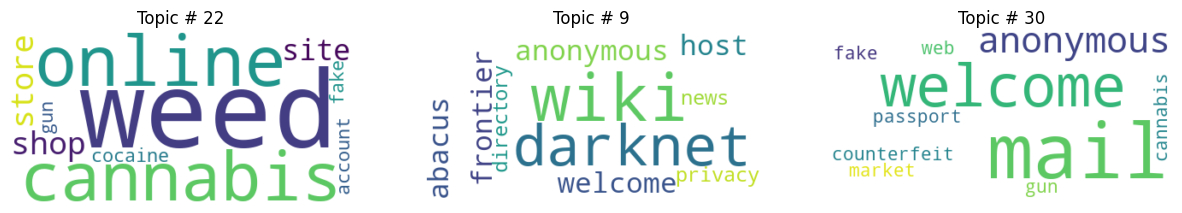

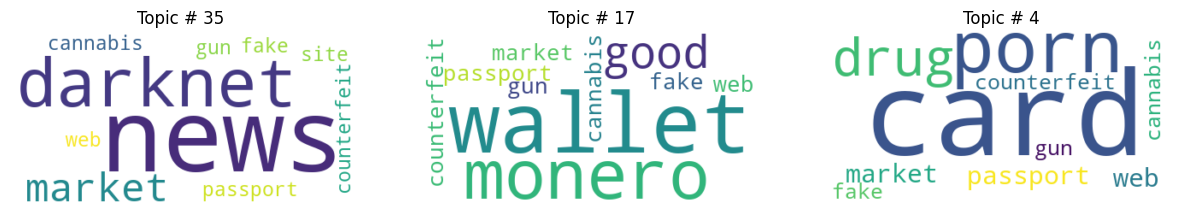

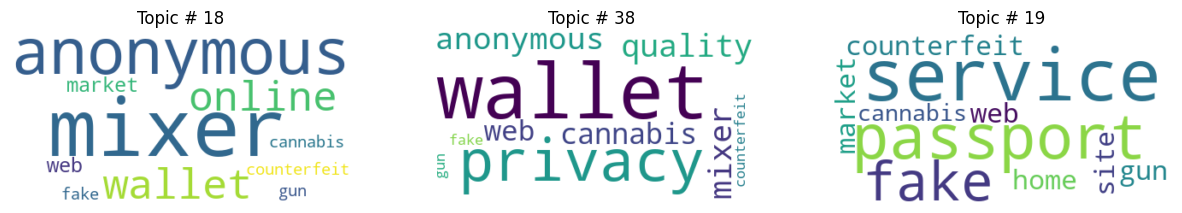

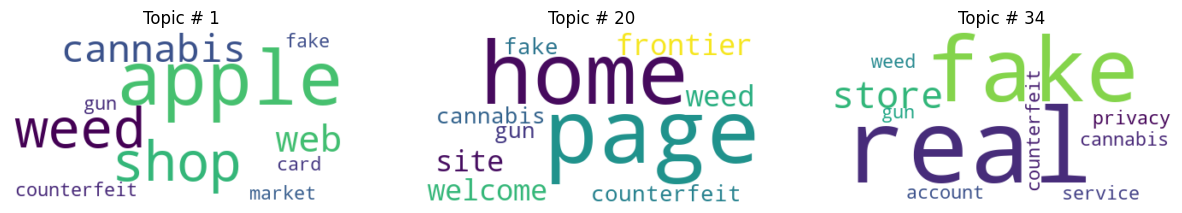

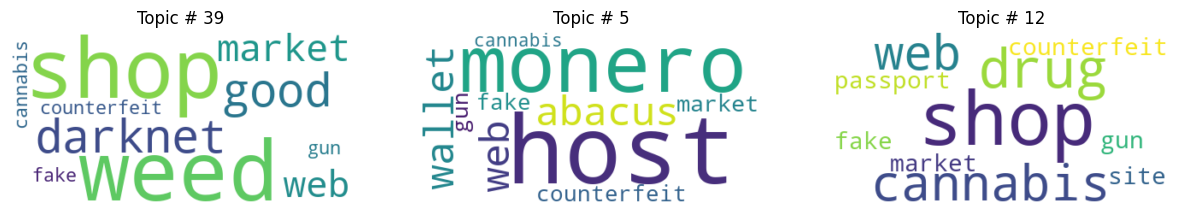

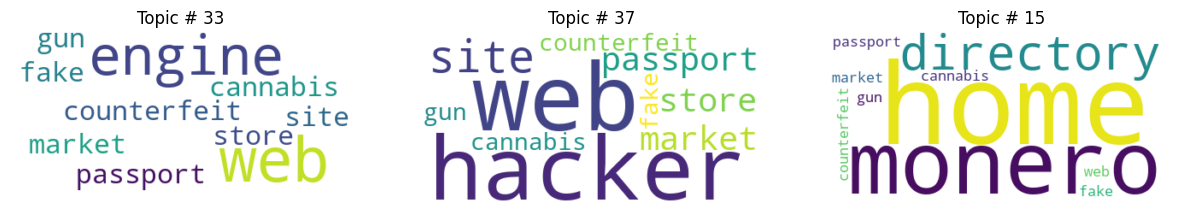

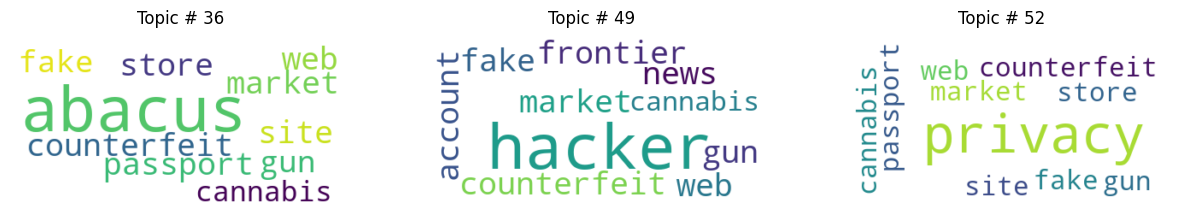

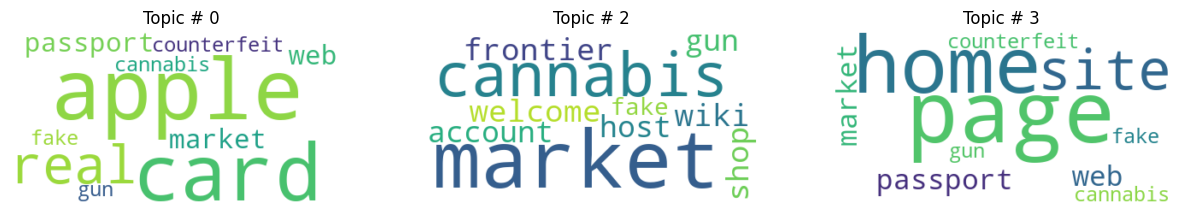

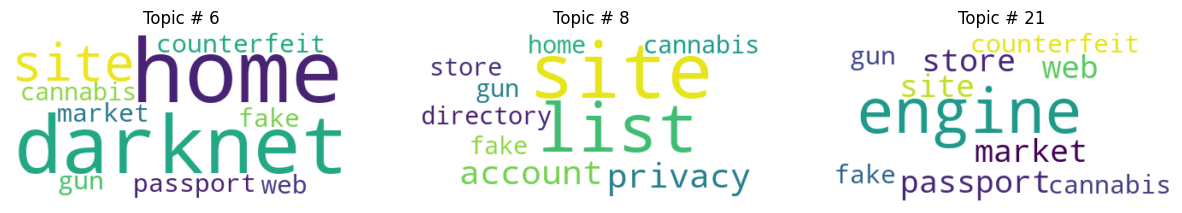

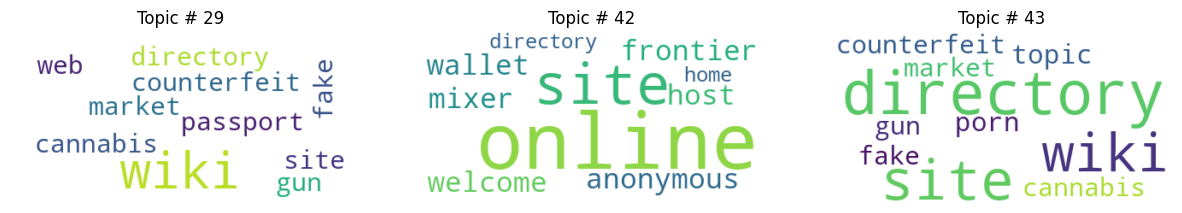

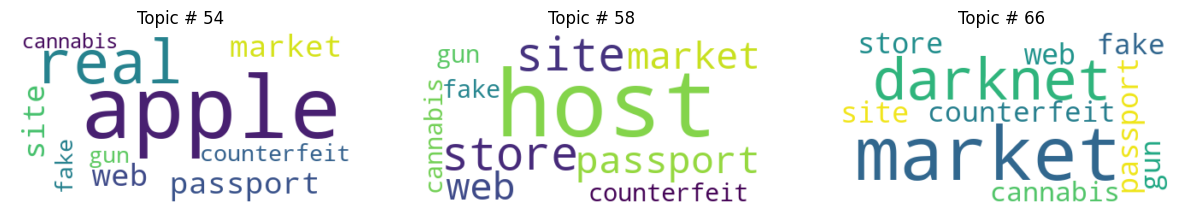

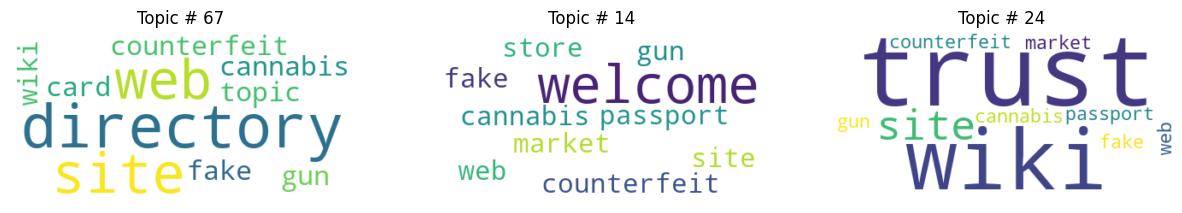

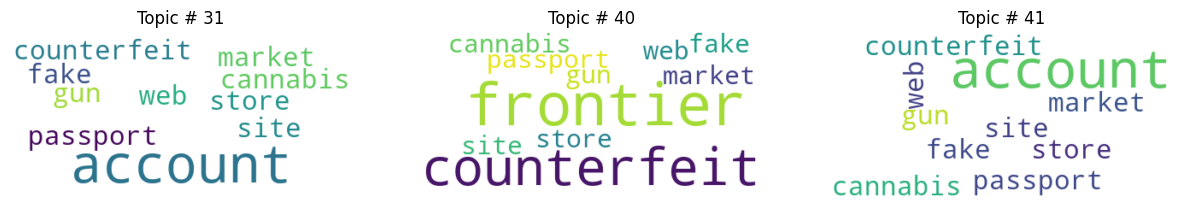

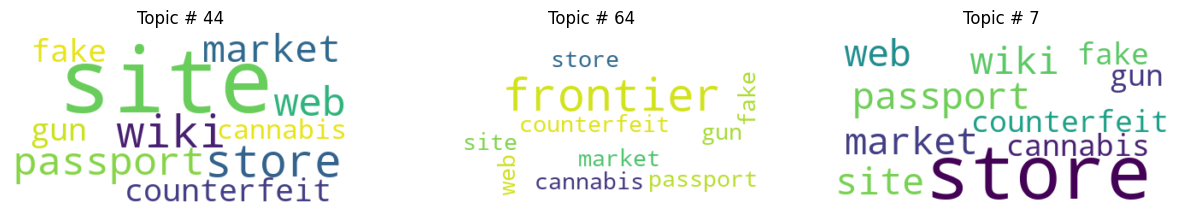

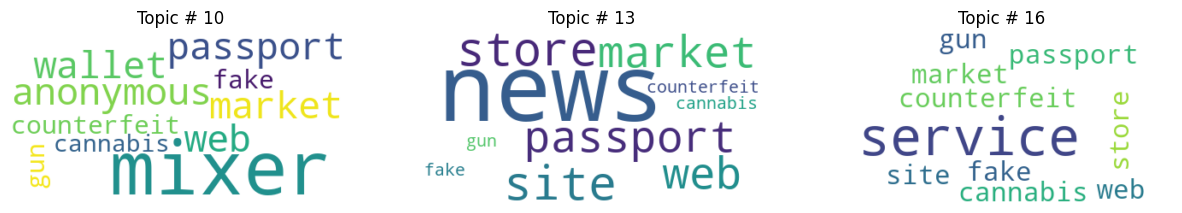

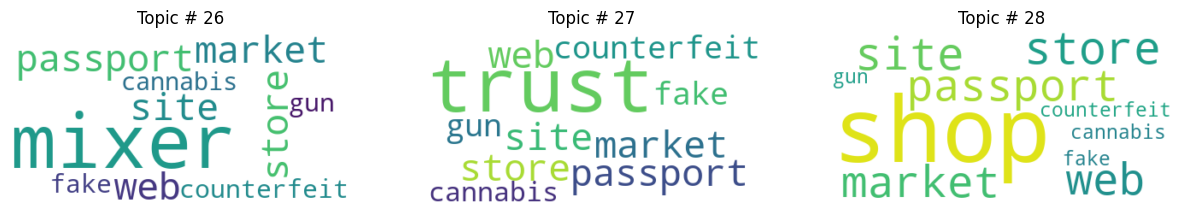

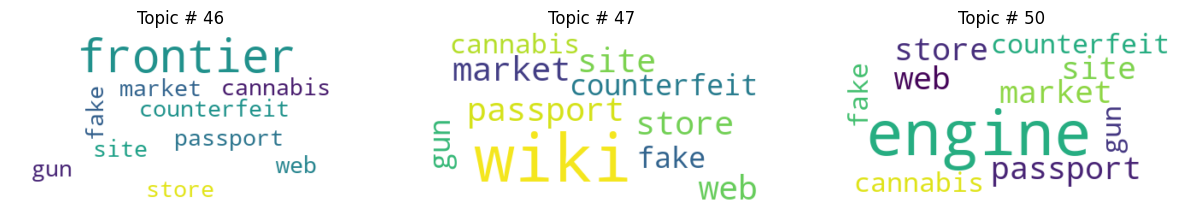

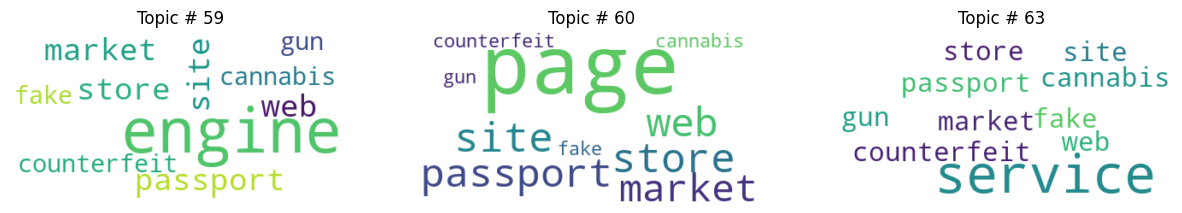

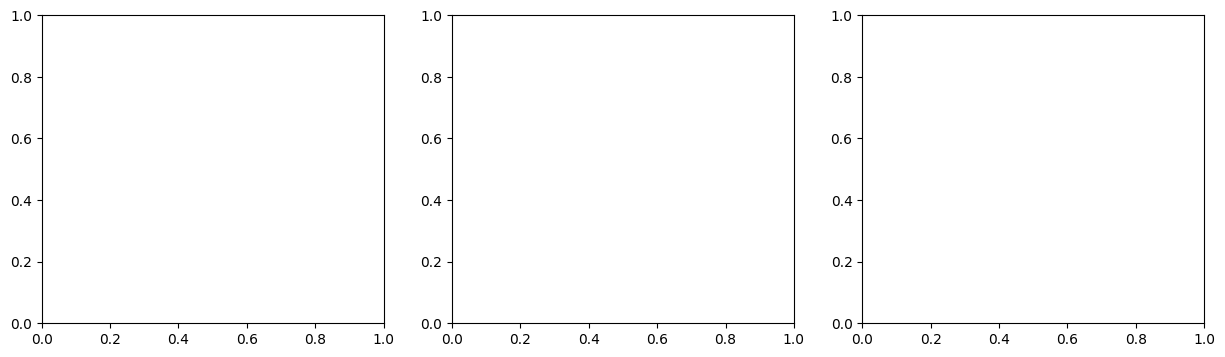

In [1032]:
hdp_topics_to_wordclouds(hdp, hdp_topics)

### Cautionary Tale 3

In [1033]:
from gensim.models import HdpModel

# Filter outlier words (e.g. appear <10 docs or in over 50% of docs)
vocab = corpora.Dictionary(word_list_lemmatized)
vocab.filter_extremes(no_below=20, no_above=0.5)
vocab.compactify()

# Build corpus
corpus = [vocab.doc2bow(words) for words in word_list_lemmatized]

# Just changing the learning rate (Kappa) and truncation level (the variable "T" is the max amount of topics over all documents, "K" is the max amount of topics over a single document)
hdp = HdpModel(corpus, vocab, gamma=1, T=30, alpha=0.1, K=8, kappa=1, random_state=20) # default kappa
hdp08 = HdpModel(corpus, vocab, gamma=1, T=30, alpha=0.1, K=8, kappa=0.8, random_state=20)
hdp06 = HdpModel(corpus, vocab, gamma=1, T=30, alpha=0.1, K=8, kappa=0.6, random_state=20)

In [1034]:
vb_model = [hdp06, hdp08, hdp]
vb_coherence =[]

for m in vb_model:
    cm = CoherenceModel(m, texts=word_list_lemmatized, corpus=corpus, dictionary=vocab, coherence='c_v')
    vb_coherence.append(cm.get_coherence())

In [1035]:
pd.DataFrame(vb_coherence, index=['hdp_kap06', 'hdp_kap08', 'hdp_kap1']).T


hdp_kap06  hdp_kap08  hdp_kap1
0   0.624394   0.624394  0.624394

In [1036]:
import pyLDAvis.gensim
py_corpus = [x for x in corpus if len(x) > 0]
prep= pyLDAvis.gensim.prepare(hdp, py_corpus, vocab)
pyLDAvis.display(prep)
